In [4]:
from PIL import Image
import torch
from torchvision import transforms
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence
import os
import pickle
import matplotlib.pyplot as plt

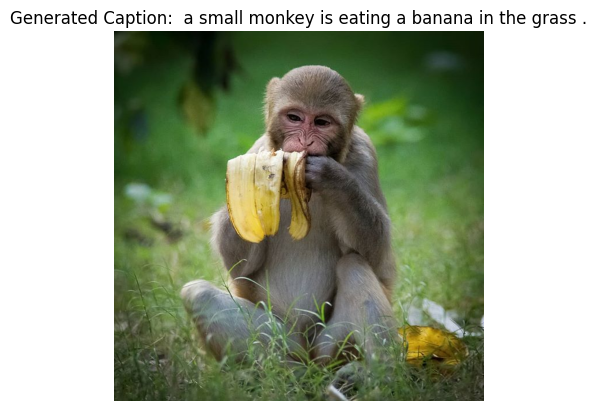

In [19]:
device = torch.device("mps")

embed_size = 256
hidden_size = 512
vocab_file = "vocab.pkl"

#Load the vocabulary
with open(os.path.join("data", vocab_file), "rb") as f:
    vocab = pickle.load(f)
    
vocab_size = len(vocab)

#initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

encoder.to(device)
decoder.to(device)

#Load the trained weights

encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

encoder.load_state_dict(torch.load(os.path.join("models", encoder_file)))
decoder.load_state_dict(torch.load(os.path.join("models", decoder_file)))

encoder.eval()
decoder.eval()

#load the test image
test_image_path = "monkey3.jpg"
test_image = Image.open(test_image_path).convert("RGB")

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_image = transform_test(test_image).unsqueeze(0) # add batch dimension
test_image = test_image.to(device)

#Pass the test img to encoder
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

with torch.no_grad():
    output = decoder.sample(features)
    

#Convert the output into a clean sentence
caption = clean_sentence(output, vocab.idx2word)
#display the test img with generated caption
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title("Generated Caption: " + caption)
plt.show()
